# Introduction

This notebook presents how to train CIFAR-10 dataset with [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) model. The main purpose is to practice implementing the past state-of-the-art deep convolutional architecture in TensorFlow so that I could improve my fast prototyping ability. 

### Section 1, 2, 5
- These sections' contents are related to preparing dataset, training, and testing procedures. These processes are borrowed from my previous notebook, so I won't explain about them much in here. You can find much more detailed explanation [HERE, MY GITHUB REPO](https://github.com/deep-diver/CIFAR10-img-classification-tensorflow)

### Section 3, 4
- These sections are what I want to focus on this notebook. The section 3 is about AlexNet's architecture based on the original paper. The section 4 is about defining loss function, optimizer, and so on. I will give a brief description about mapping between the paper and the actual implementation in TensorFlow.

## 1. CIFAR-10, CIFAR-100 Dataset Download

I have written a handy utilities in cifar10_utils.py file. It comes with some useful functions.

- **download(path)** 
   - Download the CIFAR-10 dataset and extract it. It is still a collection of raw data.
   
   
- **preprocess_and_save_data(path)** 
   - Preprocessing CIFAR-10 dataset. The entire dataset is split into training, validation, and testing datasets. Also, based on the ground truth labels, it produces a one-hot vector style of labels for each example.
   
   
- **convert_to_imagenet_size(images)** 
   - Convert CIFAR-10 size of image dataset into the ImageNet size of image (224, 224)

In [1]:
import pickle
import cifar10_utils
import cifar100_utils

In [2]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'
cifar10_utils.download(cifar10_dataset_folder_path)

cifar-10-python.tar.gz already exists
cifar10 dataset already exists


In [2]:
cifar100_dataset_folder_path = 'cifar-100-python'
cifar100_utils.download(cifar100_dataset_folder_path)

CIFAR-100 Dataset: 169MB [00:14, 11.4MB/s]                              


## 2. Preprocess the dataset

In [ ]:
cifar10_utils.preprocess_and_save_data(cifar10_dataset_folder_path)

In [3]:
cifar100_utils.preprocess_and_save_data_cifar100(cifar100_dataset_folder_path)

## 3. AlexNet Model Architecture

![AlexNet Architecture](./figure1.png)

Some more detailed mapping between paper and TensorFlow code can be found [HERE](https://github.com/deep-diver/AlexNet/blob/master/AlexNet.pdf)

In [4]:
epochs = 1
learning_rate = 0.0001
batch_size = 128

In [4]:
from alexnet import AlexNet

alexNet = AlexNet('cifar10', learning_rate)

In [5]:
from alexnet import AlexNet
    
alexNet2 = AlexNet('cifar100', learning_rate)

## 4. Training

In [6]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))
tmpValidFeatures = cifar10_utils.convert_to_imagenet_size(valid_features[:3000])

FileNotFoundError: [Errno 2] No such file or directory: 'preprocess_validation.p'

In [ ]:
save_model_path = './image_classification'

alexNet.train(epochs, batch_size, (tmpValidFeatures, valid_labels), save_model_path)

In [ ]:
valid_features, valid_labels = pickle.load(open('cifar100_preprocess_validation.p', mode='rb'))
tmpValidFeatures = cifar100_utils.convert_to_imagenet_size(valid_features[:3000])

/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [36]:
save_model_path = './image_classification_cifar100'

epochs = 1
batch_size = 128

alexNet.train_from_ckpt(epochs, batch_size, (tmpValidFeatures, valid_labels), save_model_path)

INFO:tensorflow:Restoring parameters from ./image_classification
starting training ... 
Epoch  1, CIFAR-10 Batch 1:  Validation Accuracy 0.646810
Epoch  1, CIFAR-10 Batch 2:  Validation Accuracy 0.655333
Epoch  1, CIFAR-10 Batch 3:  Validation Accuracy 0.648571
Epoch  1, CIFAR-10 Batch 4:  Validation Accuracy 0.654571
Epoch  1, CIFAR-10 Batch 5:  Validation Accuracy 0.656714


## 5. Testing

In [7]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
from sklearn.preprocessing import LabelBinarizer

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axs = plt.subplots(10, 2, figsize=(12,24))

    margin = 0.05
    ind = np.arange(n_classes)
    width = (1. - 2. * margin) / n_classes    
    
    for image_i, (feature, label_id, prediction) in enumerate(zip(features, label_ids, predictions)):
        correct_name = label_names[label_id]
        pred_name = label_names[np.argmax(prediction)]
        
        is_match = 'False'        
        
        if np.argmax(prediction) == label_id:
            is_match = 'True'
            
        predictions_array = []
        pred_names = []
        
        for index, pred_value in enumerate(prediction):
            tmp_pred_name = label_names[index]
            predictions_array.append({tmp_pred_name : pred_value})
            pred_names.append(tmp_pred_name)
        
        print('[{}] ground truth: {}, predicted result: {} | {}'.format(image_i, correct_name, pred_name, is_match))
        print('\t- {}\n'.format(predictions_array))
        
        axs[image_i][0].imshow(feature)
        axs[image_i][0].set_title(pred_name)
        axs[image_i][0].set_axis_off()
        
        axs[image_i][1].barh(ind + margin, prediction, width)
        axs[image_i][1].set_yticks(ind + margin)
        axs[image_i][1].set_yticklabels(pred_names)
        
    plt.tight_layout()

In [9]:
import skimage
import numpy as np

test_features, test_labels = pickle.load(open('preprocess_testing.p', mode='rb'))
tmpFeatures = []

for feature in test_features:
    tmpFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
    tmpFeatures.append(tmpFeature)

tmpFeatures = np.asarray(tmpFeatures)

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6391321656050956

[0] ground truth: dog, predicted result: dog | True
	- [{'airplane': 0.008115028}, {'automobile': 0.00013591461}, {'bird': 0.1802528}, {'cat': 0.08530028}, {'deer': 0.006792705}, {'dog': 0.656511}, {'frog': 0.00067765324}, {'horse': 0.059196312}, {'ship': 0.0021743611}, {'truck': 0.0008439609}]

[1] ground truth: horse, predicted result: horse | True
	- [{'airplane': 0.00041291947}, {'automobile': 4.6541863e-05}, {'bird': 0.02273434}, {'cat': 0.0011840098}, {'deer': 0.016418068}, {'dog': 0.005218465}, {'frog': 0.0010888284}, {'horse': 0.95278114}, {'ship': 5.0600418e-05}, {'truck': 6.509832e-05}]

[2] ground truth: horse, predicted result: horse | True
	- [{'airplane': 1.5857622e-06}, {'automobile': 3.1225318e-06}, {'bird': 0.00073610345}, {'cat': 4.022756e-05}, {'deer': 0.0015112961}, {'dog': 0.00011741476}, {'frog': 0.0001080699}, {'horse': 0.9974808}, {'ship': 3.6091677e-07}, {'tru

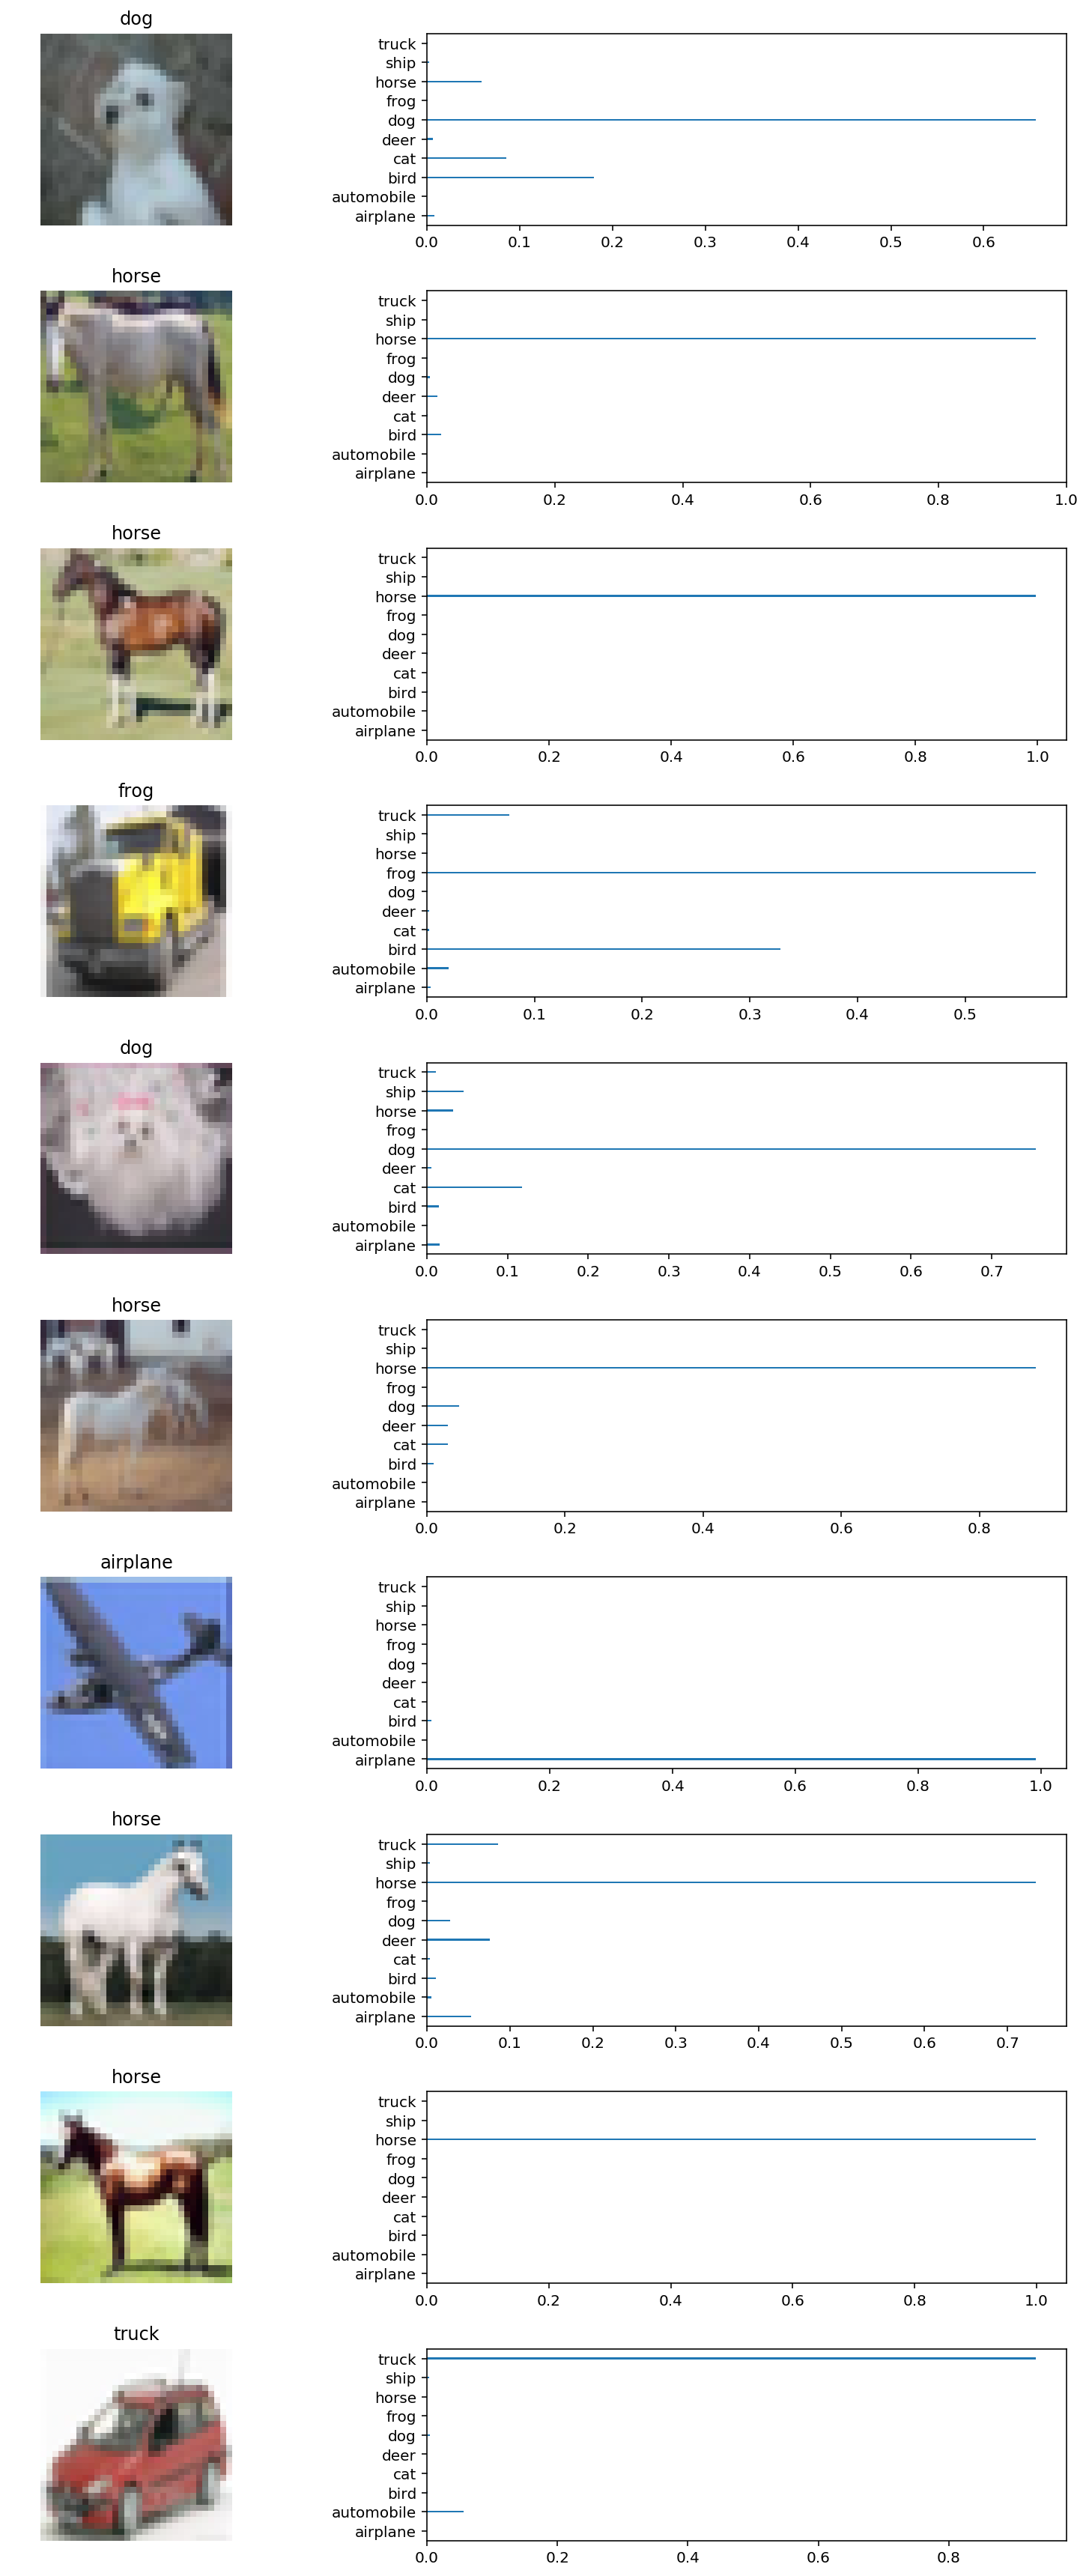

In [37]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random
import tensorflow as tf

save_model_path = './image_classification'
batch_size = 64
n_samples = 10
top_n_predictions = 5

def test_model(tmpFeatures):
    loaded_graph = tf.Graph()
    
    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        loaded_x = loaded_graph.get_tensor_by_name('input:0')
        loaded_y = loaded_graph.get_tensor_by_name('label:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        for train_feature_batch, train_label_batch in cifar10_utils.batch_features_labels(tmpFeatures, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        
        tmpTestFeatures = []
    
        for feature in random_test_features:
            tmpFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
            tmpTestFeatures.append(tmpFeature)
           
        random_test_predictions = sess.run(
            tf.nn.softmax(loaded_logits),
            feed_dict={loaded_x: tmpTestFeatures, loaded_y: random_test_labels})
        
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model(tmpFeatures)